In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
from matplotlib.pyplot import gcf
import numpy as np 
from einops import rearrange
from sklearn import metrics, cluster
from sklearn.decomposition._nmf import NMF

from collections import Counter


import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
from mpl_toolkits.mplot3d import Axes3D
import random
import sklearn
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

import numpy as np

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.models.voxel.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique, cv_nmf_missing, truncate_colormap, fix_pdcsv, fill_df_na, cv_nmf_replicates, plot_distances, plot_cv_results, plot_W_archetypes, plot_reconstructed_connectivities, get_reconstructed_connectivities, get_layers, plot_H_archetypes, get_W_archetypes, get_H_archetypes, plot_nmf_replicates, get_toplot, get_top_clusters, compute_nmf_replicates, compute_rand_indices
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3,get_indices_2ormore#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder

/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.cdnmf_fast module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/mouse_connectivity_models/mcmodels/utils.py:27: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamb

In [2]:
cmap = plt.get_cmap('Greys')
new_cmap = truncate_colormap(cmap, 0.1,1.)
INPUT_JSON = workingdirectory + '/data/meta/input_011520.json'
EXPERIMENTS_EXCLUDE_JSON = workingdirectory + '/data/meta/experiments_exclude.json'
input_data = ju.read(INPUT_JSON)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(workingdirectory, manifest_file)
cache = VoxelModelCache(manifest_file=manifest_file)
st = cache.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}
major_structures = np.load(workingdirectory + '/data/meta/major_structures.npy')
wt_conn_file =  f"{workingdirectory}/paper/connectivities/revision_thresholded/el_leafsurf_leafsmth_leafleaf_C57BL6J_080222.csv"
distance_threshold = 15
leaf_distance_file = f'{workingdirectory}/data/meta/distances_leaf_leaf.npy'
ontological_order_leafs_ipsi_contra_major_structures_file = f"{workingdirectory}/data/meta/ool_ic_majors_names_v3_0610.npy"
ontological_order_leafs_ipsi_major_structures_file = f"{workingdirectory}/data/meta/ool_i_majors_names_v3_0610.npy"
wt_conn = fix_pdcsv(pd.read_csv(wt_conn_file, header=[0, 1]))
ool_ic_majors = np.load(ontological_order_leafs_ipsi_contra_major_structures_file)
ool_i_majors = np.load(ontological_order_leafs_ipsi_major_structures_file)
reo = np.asarray([4, 7, 2, 1, 10, 9, 11, 3, 5, 8, 6, 0])
ncomp = 15
nreps = 10
bottom_thresh = -6
alpha = .0002

annotation/ccf_2017


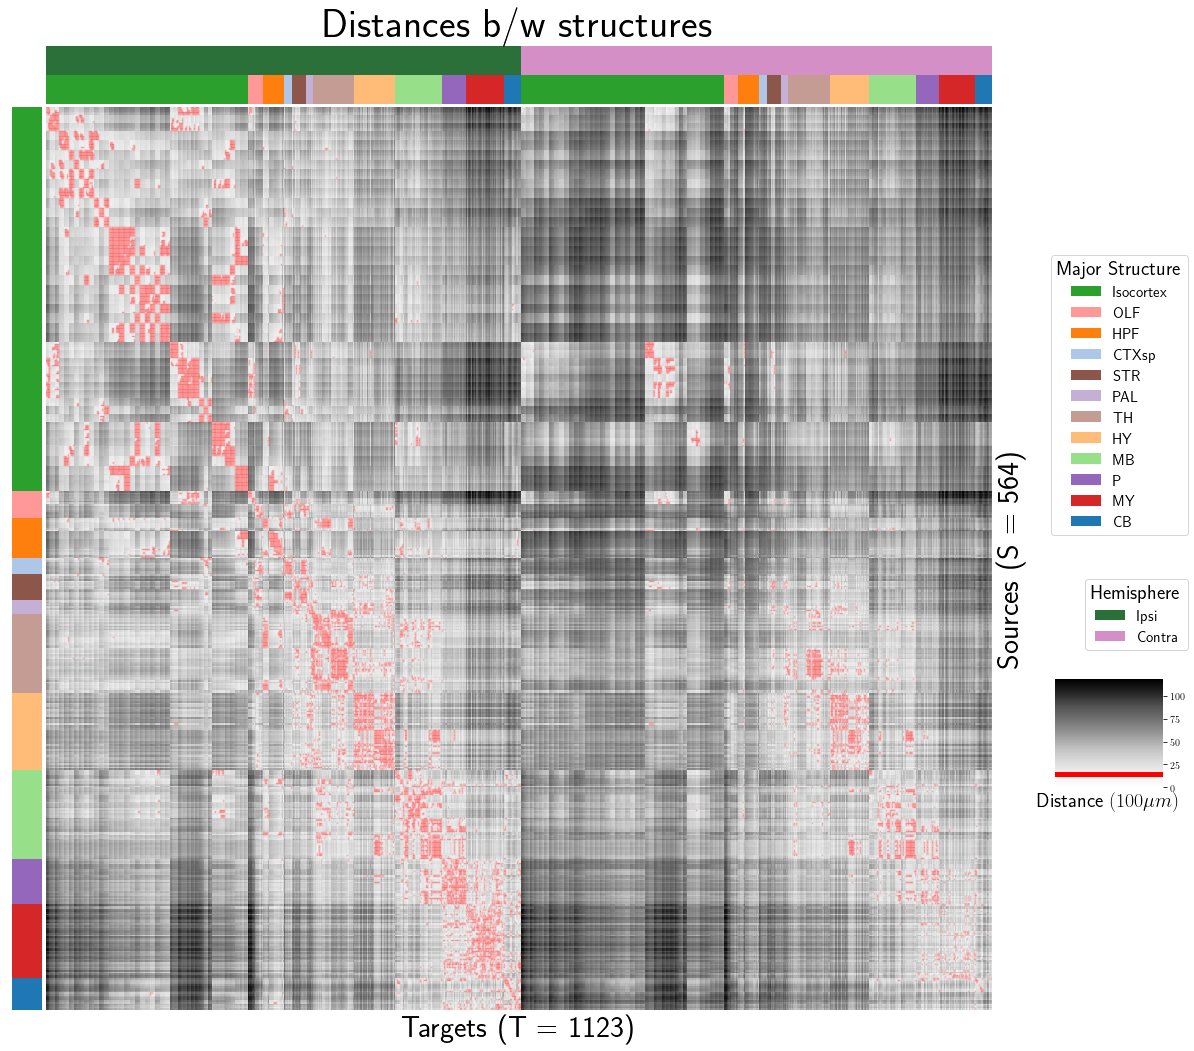

In [3]:
leaf_distances = np.load(leaf_distance_file)
g, color_str, hemis, color_hemi, combined_colors_source, source_str_colors = plot_distances(wt_conn, distance_threshold, leaf_distances, ool_ic_majors, ool_i_majors, major_structures, ia_map, reo)
g.savefig(f'{workingdirectory}/paper/KoelleConn_revision/figs/distances_leafs.png', bbox_inches = 'tight',pad_inches = 0)

In [4]:
tr_results, te_results = cv_nmf_replicates(wt_conn, distance_threshold, leaf_distance_file)

  0%|                                                                                                                                                                                                                         | 0/8 [00:00<?, ?it/s]/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will b

/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:2464: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in ve

/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is depre

/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is depre

/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is depre

/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 6/8 [03:18<01:12, 36.27s/it]/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will b

/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is depre

/Users/samsonkoelle/mouse_connectivity_models/mcmodels/utils.py:27: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams["text.latex.preamble"] = [r"\usepackage{amsmath}"]


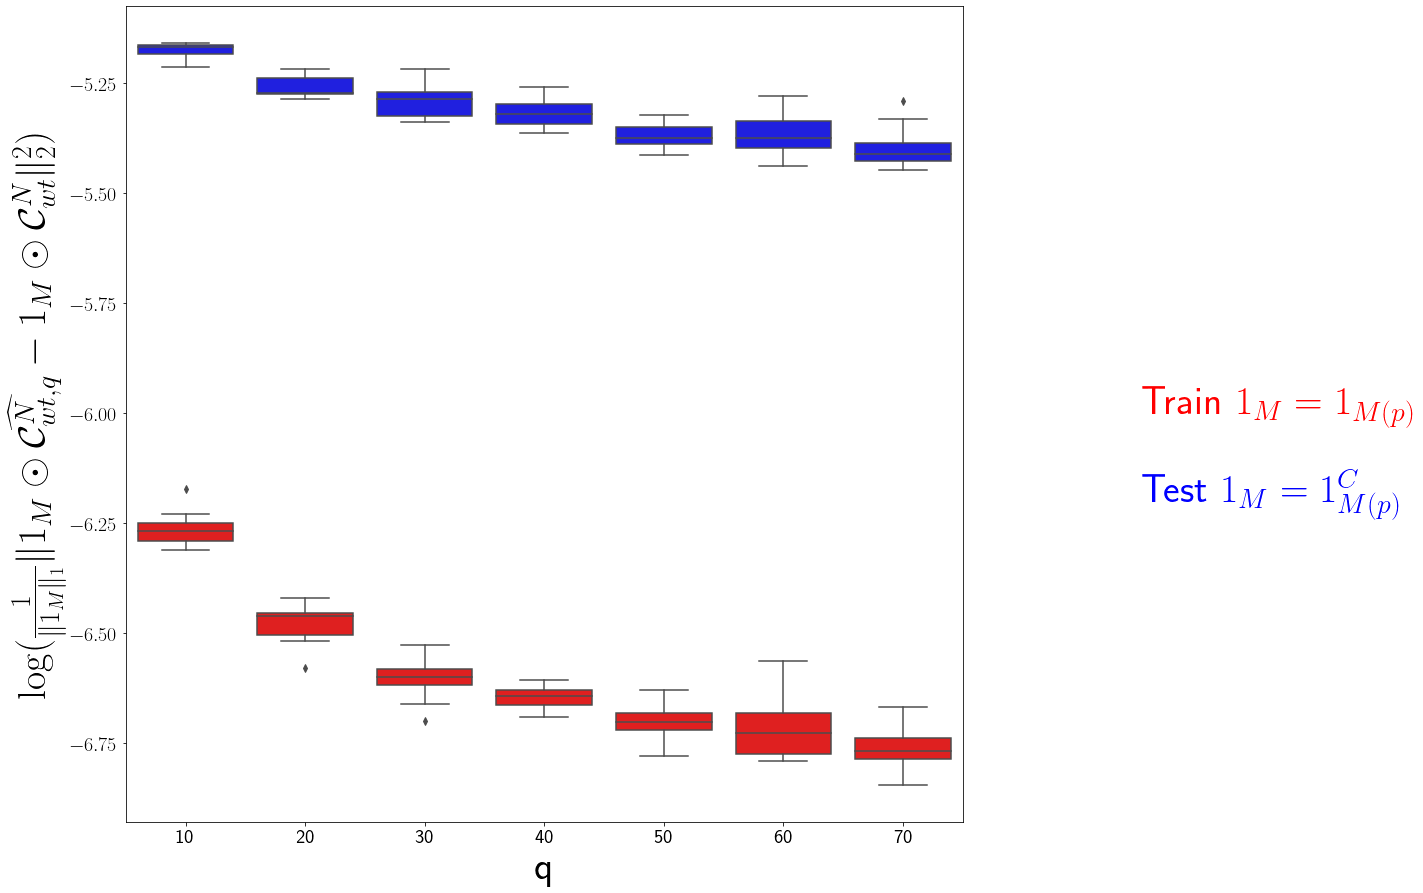

In [5]:
fig = plot_cv_results(te_results, tr_results)
fig.savefig(f'{workingdirectory}/paper/KoelleConn_revision/figs/nmf_test_train.png', bbox_inches = 'tight',
   pad_inches = 0)

In [6]:
combined, ids, data = compute_nmf_replicates(wt_conn, distance_threshold, ncomp, nreps, leaf_distances )
compute_rand_indices(combined)

0


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


2


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


3


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


4


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


5


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


6


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


7


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


8


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


9


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:2464: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0
1
2
3
4
\begin{tabular}{lrrrrr}
\toprule
{} &          0 &          1 &         2 &          3 &          4 \\
\midrule
q          &  10.000000 &  20.000000 &  30.00000 &  40.000000 &  50.000000 \\
Rand index &   0.775675 &   0.896087 &   0.91431 &   0.917758 &   0.939885 \\
\bottomrule
\end{tabular}



In [7]:
top_clust_inds, kmeans, clusts, topclusts = get_top_clusters(combined)
toplot, combined_colors, combined_colors_targ, sel_labels, sel_lut, component_colors, targ_str_lut, layer_labels_col = get_toplot(wt_conn, kmeans, ncomp, nreps, top_clust_inds,bottom_thresh, ool_ic_majors, ool_ic_majors, clusts, combined)

/Users/samsonkoelle/mouse_connectivity_models/mcmodels/utils.py:212: RuntimeWarning: divide by zero encountered in log10
  np.log10(combined[kmeans.labels_.argsort()]), index=combined_colors.index


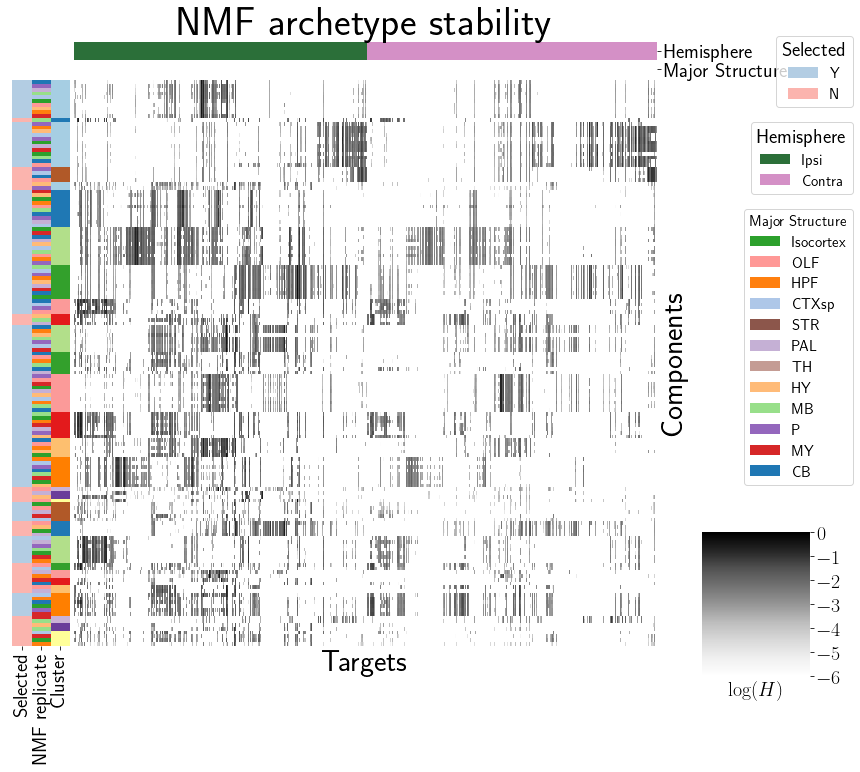

In [8]:
g = plot_nmf_replicates(toplot, combined_colors , combined_colors_targ, reo, color_str, hemis, color_hemi, sel_labels, major_structures, sel_lut)
g.savefig(f'{workingdirectory}/paper/KoelleConn_revision/figs/nmfcluster.png', bbox_inches = 'tight', pad_inches = 0)

In [9]:
log_thresh_H_archetypes, H_archetypes = get_H_archetypes(ncomp, wt_conn, kmeans, topclusts, bottom_thresh, combined, toplot)

/Users/samsonkoelle/mouse_connectivity_models/mcmodels/utils.py:355: RuntimeWarning: divide by zero encountered in log10
  log_thresh_archetypes = np.log10(archetypes)


In [10]:
# Do NNLS part of NMF algorithm with mean archetypes
log_thresh_W_archetypes, W = get_W_archetypes(data, ncomp, H_archetypes, alpha, bottom_thresh, combined_colors_source, ids)

/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


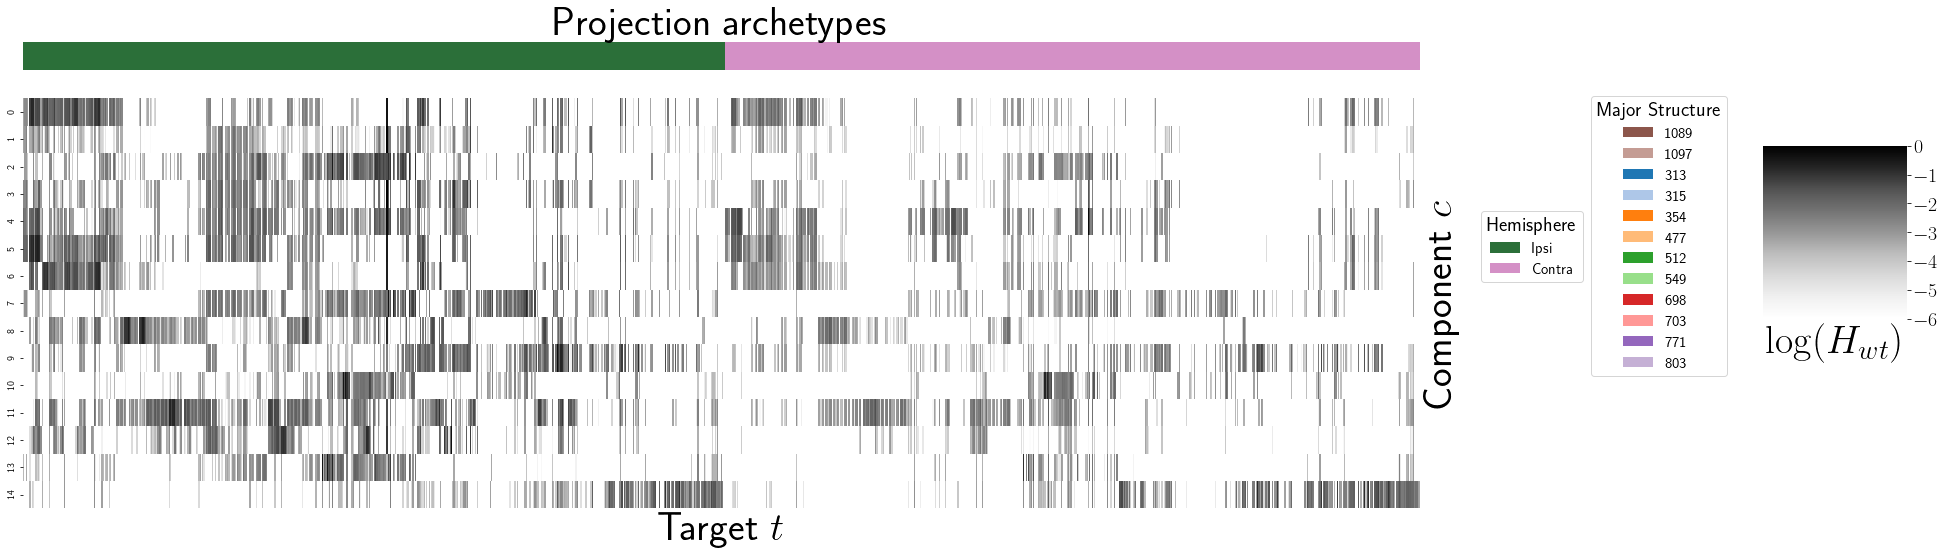

In [11]:
targ_str_labels = np.asarray([ia_map[ool_ic_majors[i ]] for i in range(len(ool_ic_majors))])
g = plot_H_archetypes(log_thresh_H_archetypes, combined_colors_targ, component_colors, np.asarray(ool_ic_majors, dtype = str), targ_str_lut, color_hemi, hemis)
g.savefig(f'{workingdirectory}/paper/KoelleConn_revision/figs/H_wt', pad_inches = 0)

In [12]:
layers, layer_colors_row, combined_colors_source2, layer_lut_row = get_layers(wt_conn, ids,source_str_colors)

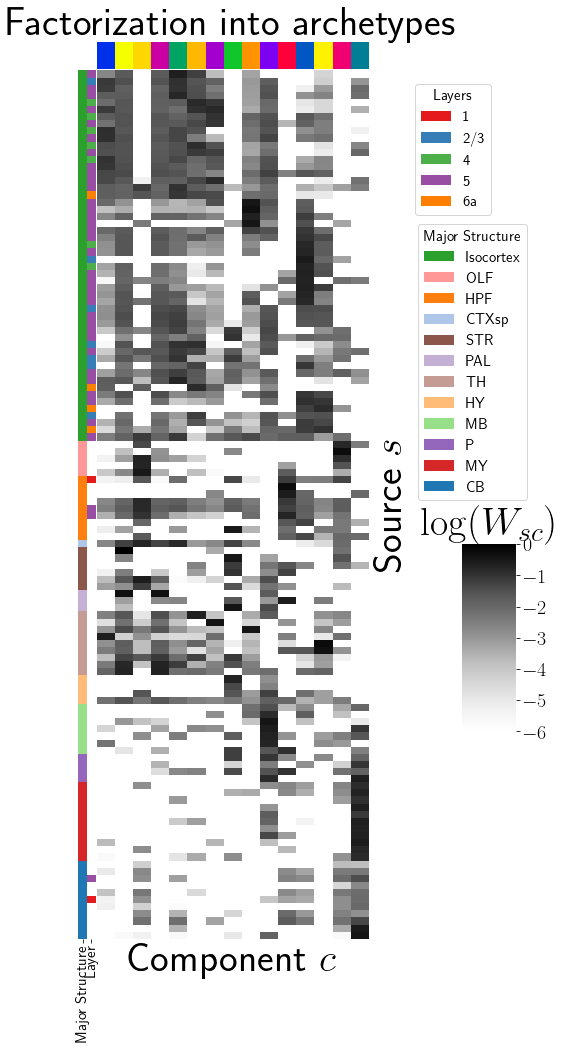

In [13]:
g = plot_W_archetypes(log_thresh_W_archetypes, combined_colors_source2, component_colors, major_structures, reo, color_str, layer_labels_col, layer_lut_row)
g.savefig(f'{workingdirectory}/paper/KoelleConn_revision/figs/W_wt', pad_inches = 0)

/Users/samsonkoelle/mouse_connectivity_models/mcmodels/utils.py:493: RuntimeWarning: divide by zero encountered in log10
  output = np.log10(W @ H)


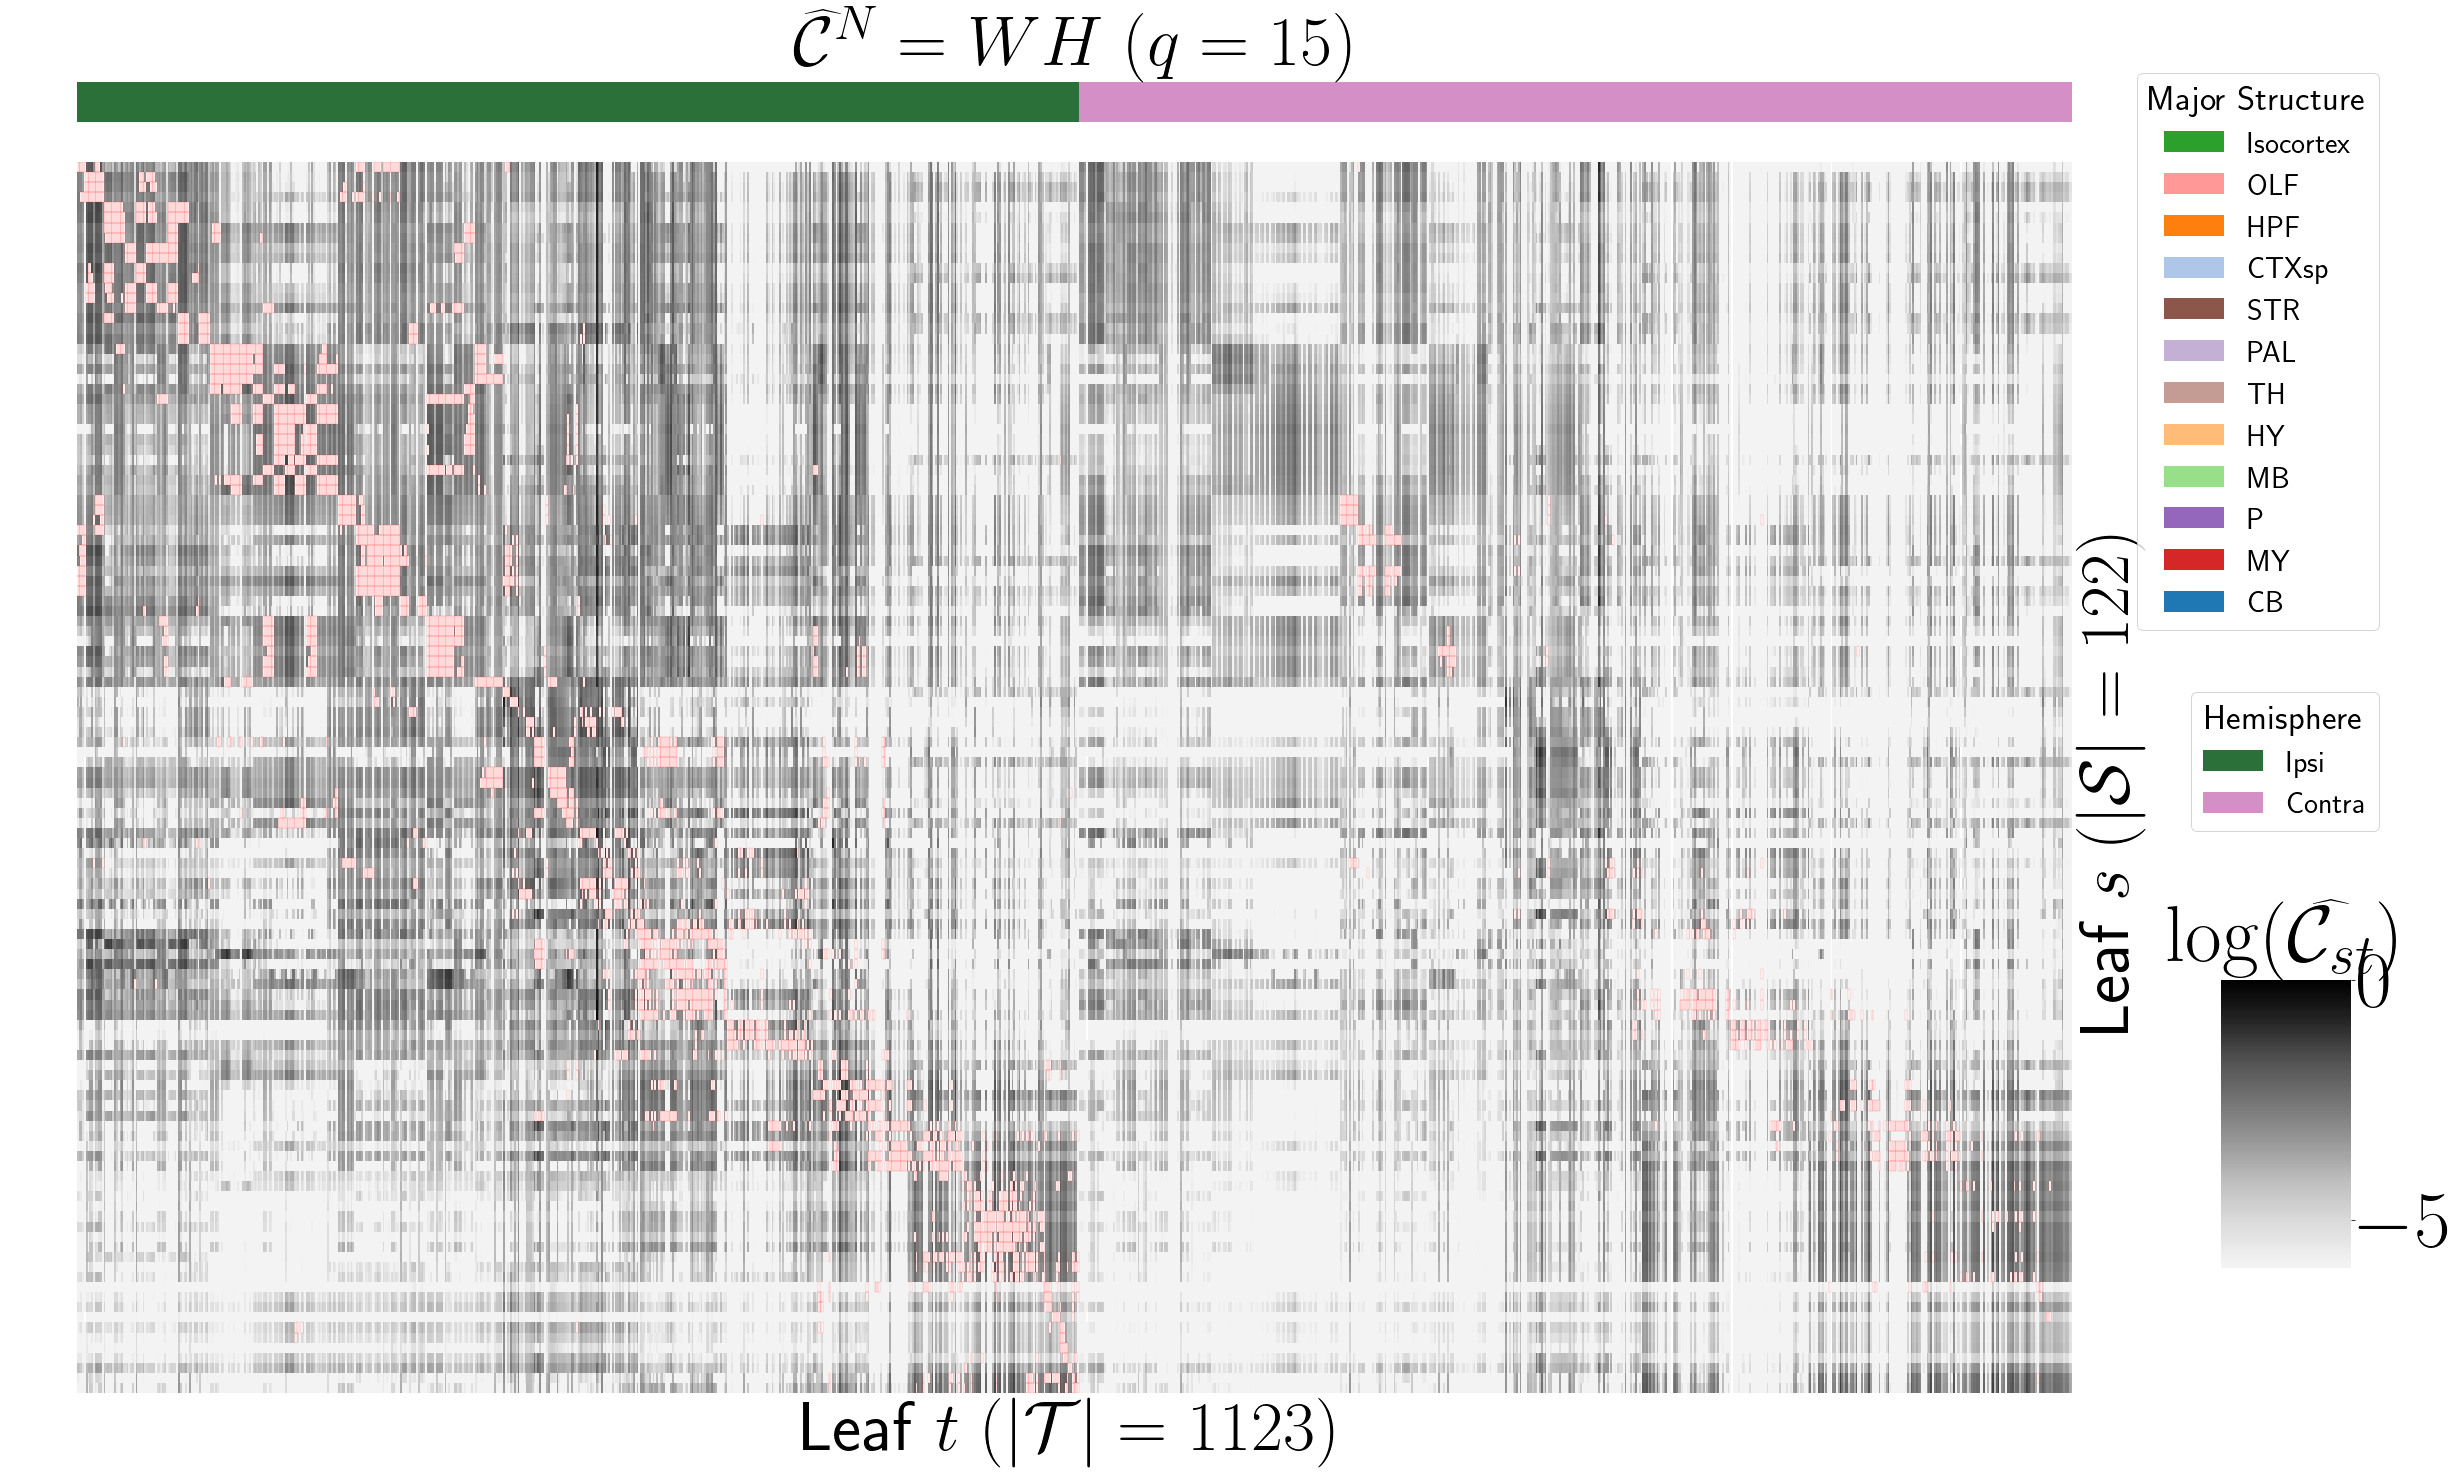

In [14]:
output, low_values2, combined_colors_targ, combined_colors_source, source_str_colors = get_reconstructed_connectivities(W, H_archetypes, data, wt_conn, leaf_distances, ool_ic_majors , ool_i_majors, ids)
g = plot_reconstructed_connectivities(output, combined_colors_targ, combined_colors_source, new_cmap, reo, major_structures, color_str, low_values2,hemis, color_hemi)
g.savefig(f"{workingdirectory}/paper/KoelleConn_revision/figs/conn_leafs_recon.png", bbox_inches = 'tight',pad_inches = 0)

In [15]:
#Look at distribution of projection distances ofsources from different cre lines with these components.  Certain components represent the behavior of certain cre lines
#Look at accuracy of reconstructions with more components

In [16]:
Tlx3_conn = pd.read_csv(workingdirectory+ "/paper/connectivities/revision_thresholded/el_leafsurf_leafsmth_leafleaf_Tlx3-Cre_PL56_080222.csv",   header=[0, 1])
wt_conn = pd.read_csv(workingdirectory+'/paper/connectivities/revision_thresholded/el_leafsurf_leafsmth_leafleaf_C57BL6J_080222.csv',   header=[0, 1])
#wt_conn = pd.read_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/connectivities/el_sumsurf_leafsmth_leafleaf_C57BL6J0428.csv',   header=[0, 1])
Cux2_conn = pd.read_csv(workingdirectory+ '/paper/connectivities/revision_thresholded/el_leafsurf_leafsmth_leafleaf_Cux2-IRES-Cre_080222.csv', header=[0, 1])
Ntsr1_conn = pd.read_csv(workingdirectory+ '/paper/connectivities/revision_thresholded/el_leafsurf_leafsmth_leafleaf_Ntsr1-Cre_GN220_080222.csv',  header=[0, 1])
Rbp4_conn = pd.read_csv(workingdirectory+ '/paper/connectivities/revision_thresholded/el_leafsurf_leafsmth_leafleaf_Rbp4-Cre_KL100_080222.csv',   header=[0, 1])

wt_conn = fix_pdcsv(wt_conn)
Cux2_conn = fix_pdcsv(Cux2_conn)
Ntsr1_conn = fix_pdcsv(Ntsr1_conn)
Rbp4_conn = fix_pdcsv(Rbp4_conn)
Tlx3_conn = fix_pdcsv(Tlx3_conn)

wt_conn_log= np.log10(wt_conn)
Cux2_conn_log = np.log10(Cux2_conn)
Ntsr1_conn_log = np.log10(Ntsr1_conn)
Rbp4_conn_log= np.log10(Rbp4_conn)
Tlx3_conn_log= np.log10(Tlx3_conn)


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in reciprocal
  if __name__ == '__main__':


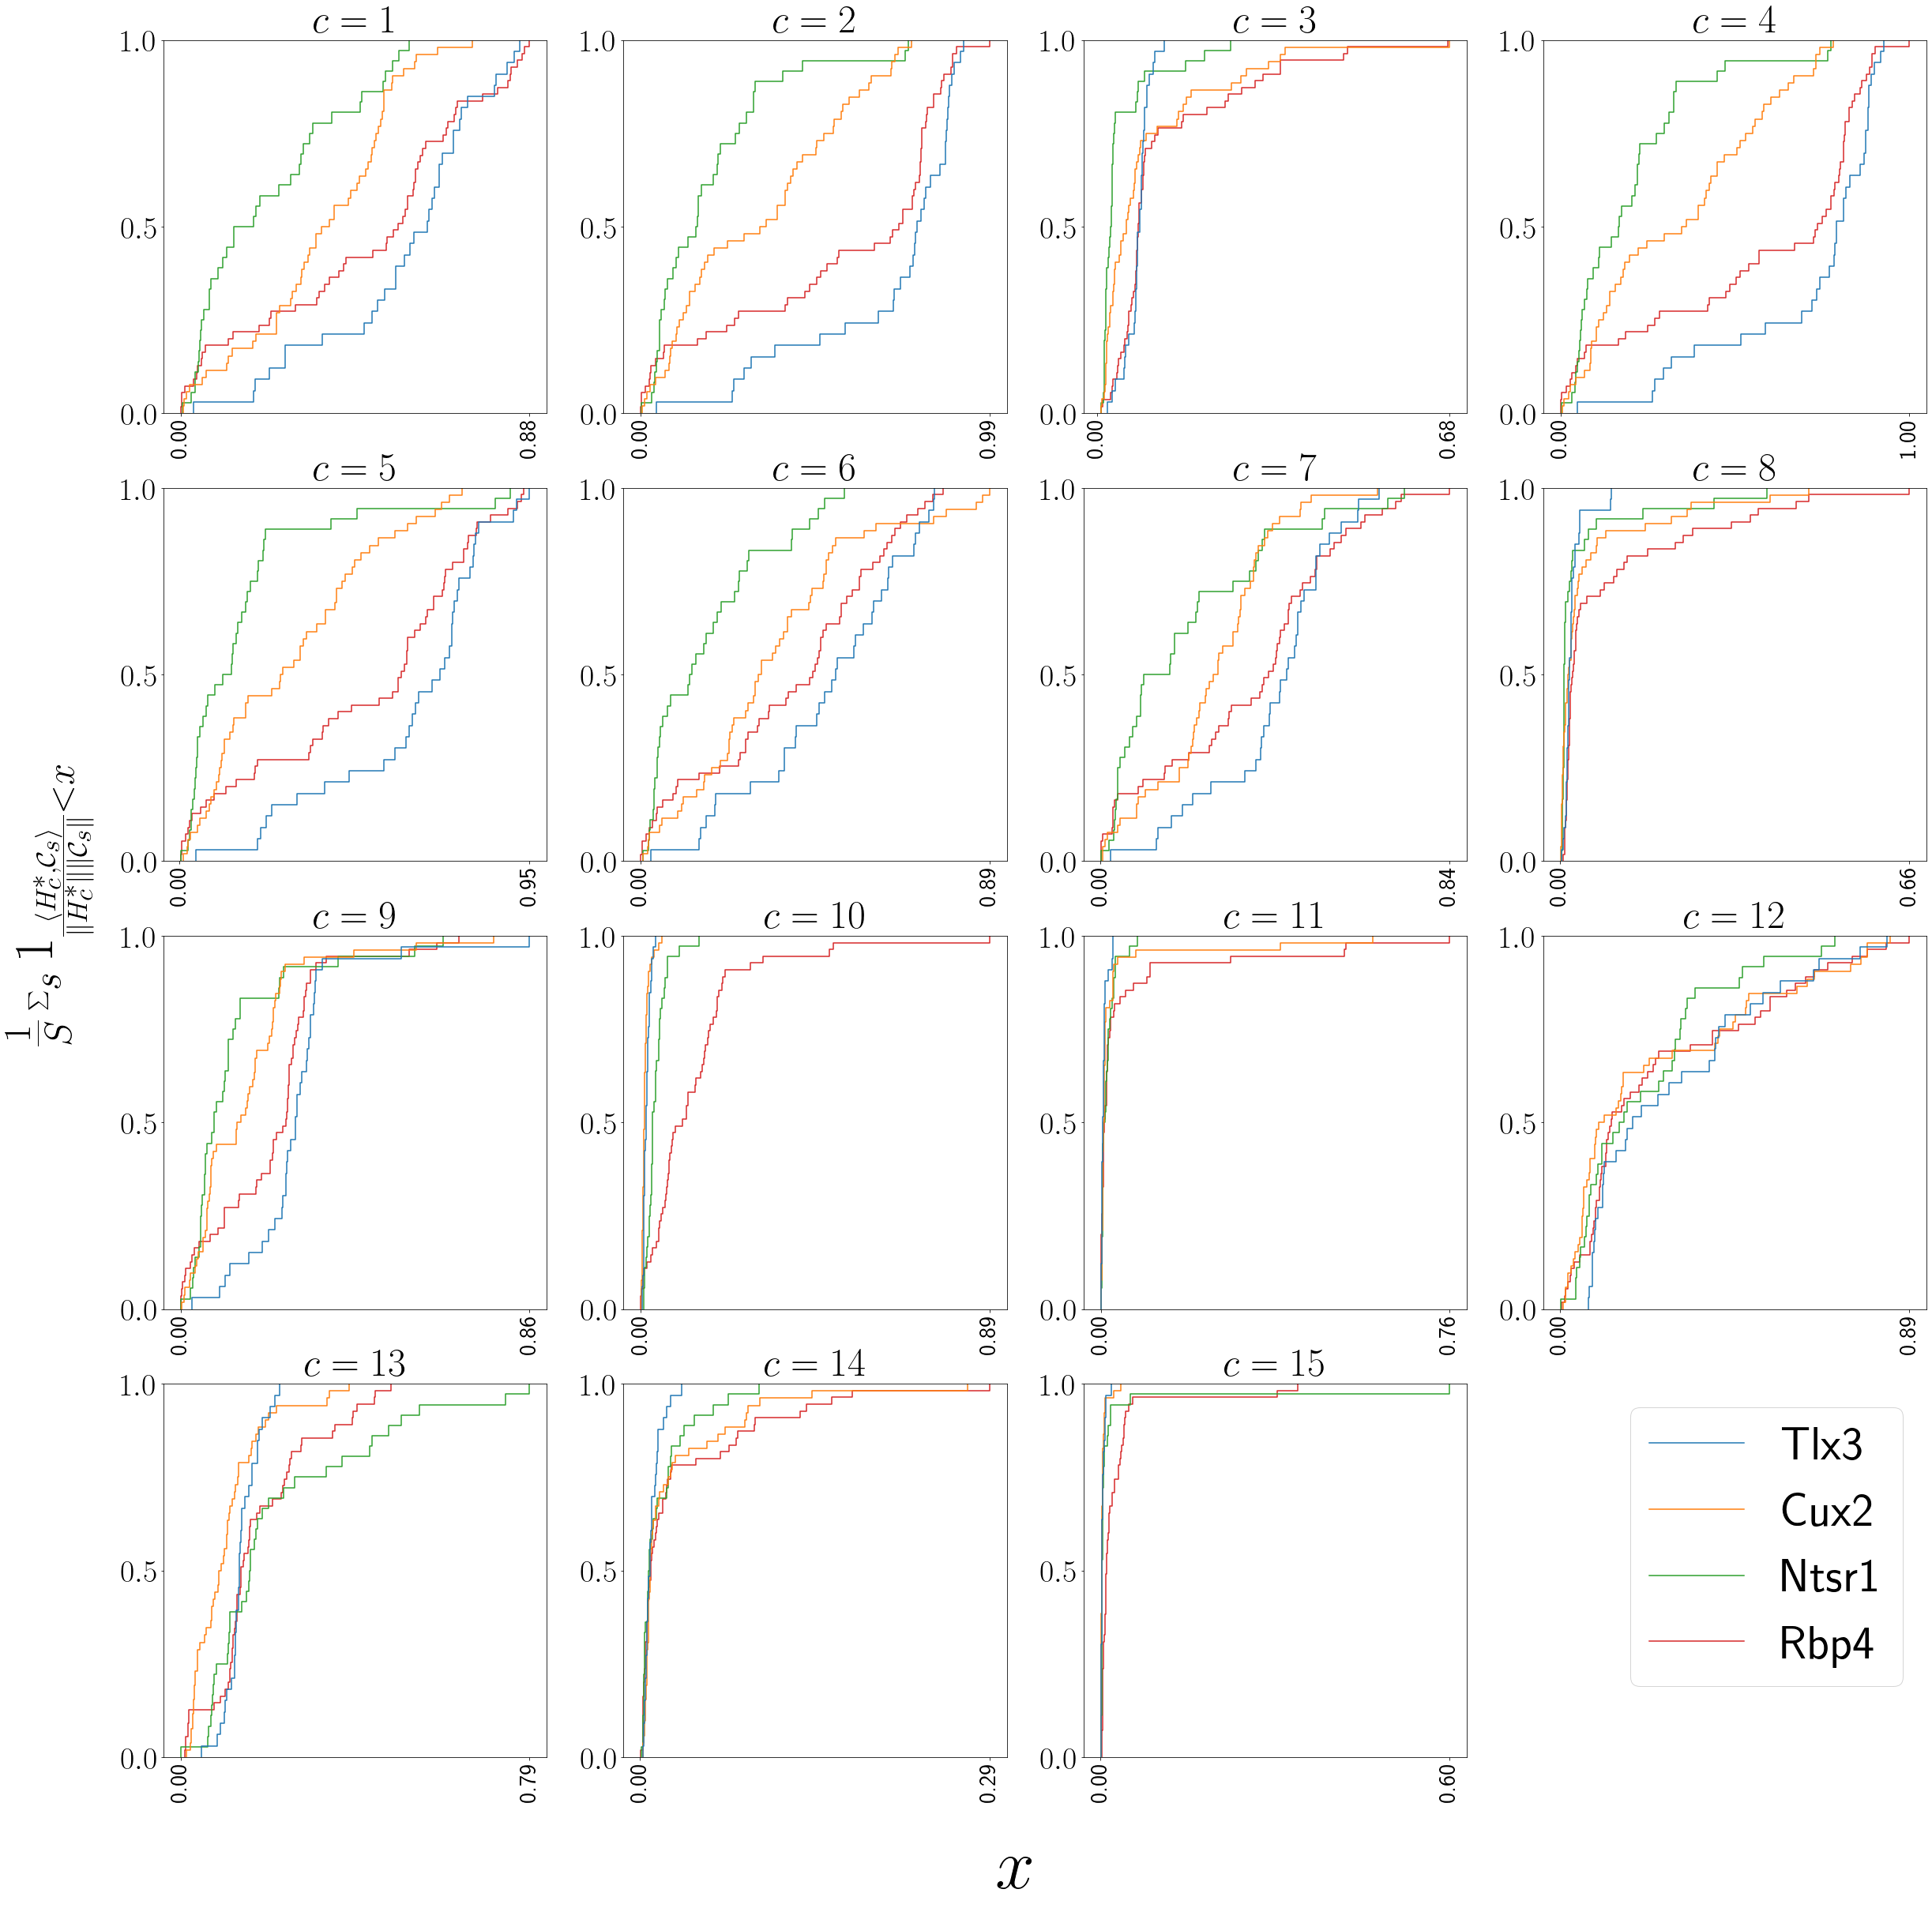

In [17]:
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics.pairwise import cosine_similarity
comparison_types = [Tlx3_conn, Cux2_conn, Ntsr1_conn, Rbp4_conn]
names = ['Tlx3','Cux2', 'Ntsr1', 'Rbp4']
scores = []
H_arch_normalized = np.einsum('i j , i -> i j', H_archetypes, H_archetypes.sum(axis = 1)**(-1))
for ct in comparison_types:
#     scores.append(H_arch_normalized  @ ct.transpose() )
    ct_norm = np.asarray([np.sqrt(np.nansum(np.square(ct.iloc[i]))) for i in range(ct.shape[0])])**(-1)
    H_norm = np.linalg.norm(H_arch_normalized, axis = 1)**(-1)
    scores.append(np.einsum('i, i j -> i j', H_norm  ,H_arch_normalized) @ np.einsum('i, i j -> i j', ct_norm , ct ).transpose())
#     scores.append(cosine_similarity(H_arch_normalized, ct))

fig, axes = plt.subplots(4,4, figsize = (40,40))
for p in range(15):
    val_list = []
    name_list = []
    for i,ct in enumerate(comparison_types):
        values = scores[i][p] #scores[i].iloc[p]
        val_list.append(values[~np.isnan(values)])
        for j,v in enumerate(values[~np.isnan(values)]):
            name_list.append(names[i])
            
    val_list = np.hstack(val_list)
    combo = pd.DataFrame(val_list, name_list)
    combo.reset_index(drop=False, inplace=True)
    combo.columns = ['Cre-line', 0]
    sns.ecdfplot(combo, ax = axes[math.floor(p/4), p%4], hue = "Cre-line", x = 0)
    axes[math.floor(p/4), p%4].set_title(r"$c = {}$".format(p+1), fontsize = 50)
    axes[math.floor(p/4), p%4].set_xlabel('')
    axes[math.floor(p/4), p%4].set_ylabel('')

    legend = axes[math.floor(p/4), p%4].get_legend()

    axes[math.floor(p/4), p%4].get_legend().remove()
    handles = legend.legendHandles
    
    axes[math.floor(p/4), p%4].set_yticks([0,.5, 1.])
    xticks = [0,combo[0].max()]
    axes[math.floor(p/4), p%4].set_xticks(xticks)

    [tick.label.set_fontsize(30) for tick in axes[math.floor(p/4), p%4].xaxis.get_major_ticks()]
    [tick.label.set_rotation(90) for tick in axes[math.floor(p/4), p%4].xaxis.get_major_ticks()]
    [tick.label.set_fontsize(40) for tick in axes[math.floor(p/4), p%4].yaxis.get_major_ticks()]
    axes[math.floor(p/4), p%4].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
labels = combo['Cre-line'].unique()
axes[3, 3].legend(handles,labels, prop={'size': 60})
  
axes[3, 3].set_axis_off()

fig.text(0.5, 0.075, r"$x$", ha='center', va='center', size = 90)
fig.text(0.075, 0.5, r"$\frac{1}{S} \sum_{s} 1_{\frac{\langle H_{c}^*, \mathcal C_s \rangle} {\|H_{c}^*\|\| \mathcal C_s\| } < x}$", ha='center', va='center', size = 70, rotation = 90)
fig.savefig(f'{workingdirectory}/paper/KoelleConn_revision/figs/component_explanations.png', bbox_inches = 'tight', pad_inches = 0)
